In [3]:
# !pip uninstall zonepy -y
# !pip install git+https://github.com/vibe-lab-gsd/zonepy.git

Found existing installation: zonepy 0.5.0
Uninstalling zonepy-0.5.0:
  Successfully uninstalled zonepy-0.5.0
  Cloning https://github.com/vibe-lab-gsd/zonepy.git to /private/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/pip-req-build-1g_5qzfu
  Running command git clone --filter=blob:none --quiet https://github.com/vibe-lab-gsd/zonepy.git /private/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/pip-req-build-1g_5qzfu
  Resolved https://github.com/vibe-lab-gsd/zonepy.git to commit 940d86cf1e2c19ce96347f5b52a204430fddc055
  Preparing metadata (setup.py) ... done
  Created wheel for zonepy: filename=zonepy-0.5.0-py3-none-any.whl size=44267 sha256=c8d59a04ac567b37369f93dec1822a101f50523acf262347b5f7e94c7f0855db
  Stored in directory: /private/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/pip-ephem-wheel-cache-tc0mvj38/wheels/33/a7/db/83a2022a2a7e73df5b8f014c4abe97b84515bd075f5fe5b8d7
Successfully built zonepy


In [2]:
# pip install pandas==2.1.4 geopandas==0.14.2

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import glob

from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping

from joblib import Parallel, delayed
from tqdm import tqdm

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks
from zonepy import zp_run_zoning_checks

# Re-construct the Data

In [4]:
# tidyparcel_feeds = tidyparcel_geo_feeds.merge(tidyparcel_dim_feeds[['parcel_id','lot_width','lot_depth','lot_area','confidence']], on='parcel_id', how='left')

# mask = tidyparcel_feeds['side'] != 'centroid'
# tidyparcel_feeds.loc[mask, ['lot_width','lot_depth','lot_area','confidence']] = np.nan

# unqiue_id = tidyparcel_feeds[tidyparcel_feeds['confidence'] == 'non_confidence_parcel']['parcel_id'].unique()
# tidyparcel_feeds.loc[(tidyparcel_feeds['parcel_id'].isin(unqiue_id)) & (tidyparcel_feeds['side'] != 'centroid'), 'side'] = 'Unknown'

# tidyparcel_feeds[['Prop_ID','parcel_id','parcel_label','side','lot_width','lot_depth','lot_area','geometry']].to_crs("EPSG:4326").to_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson", driver='GeoJSON')
# tidyparcel_feeds[tidyparcel_feeds['side'] == 'centroid'][['parcel_id','landuse','landuse_spec','confidence']].to_csv(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds_land_use.csv", index=False)

In [5]:
# tidyparcel_feeds = gpd.read_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson")
# tidyparcel_feeds

In [6]:
# # Example usage:
# process_all_districts(
#     tidyparcel_path="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson",
#     district_folder="/Users/houpuli/Dropbox/ceshi/ozfs_without_overlay/",
#     output_folder="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds/"
# )

# Step 1: some necessary functions
For the functions of this part, you don't have to run them, because all of them were intergrated into the later functions, I list them here just for your reference.

## `zp_get_crs` function
Kamryn uploaded a state plane reference to [guihub](https://raw.githubusercontent.com/KamrynMansfield/tidyzoning/main/inst/extdata/sp_crs.geojson), and this function will refer you to get the correct crs of the geojson file. And this function is used in the `zp_read_pcl` function.

In [9]:
Addison_district = gpd.read_file(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
print('The matched crs is EPSG:', zp_get_crs(Addison_district.loc[[0]]))

The matched crs is EPSG: 32138


# Step 2: Read files

## 01.`zp_read_dist` function
this function is for reading district info, and it will deleted those districts without valid geometry and re-index the structure, besides it will also auto-reproject the district data to the target crs by using "zp_get_crs" fucntion, while this function also allow you to input the target crs by yourself.

In [10]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=3857)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:3857


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((-10780184.101 3887684.743, -10...",0
3,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((-10777090.621 3888246.808, -10...",3
4,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((-10778516.328 3891864.967, -10...",4
5,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((-10781846.642 3887084.891, -10...",5
6,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((-10778798.181 3888383.694, -10...",6


In [11]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=None)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:32138


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((755203.329 2142711.882, 755202...",0
3,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((757793.793 2143223.087, 757790...",3
4,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((756548.273 2146227.618, 756547...",4
5,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((753814.918 2142188.501, 753814...",5
6,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((756357.973 2143314.560, 756354...",6


## 02.`zp_read_pcl` function
this funcion is for reading parcel info, and it will auto-match the same crs with the "district dataframe" created above(you cannot define the crs by yourself, because we must keep the same crs between "dist data" and "parcel_data", if you want to change the crs, you have define a crs by above "zp_read_dist" fucntion, and run "zp_read_pcl" fucntion again, and you will find the crs will change). Besides, this function will also add a "zoning_id" column to each parcel centroid row, which is the index of the district that contains the parcel centroid.

In [12]:
Addison_parcels = zp_read_pcl(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyparcel_feeds/Addison.parcel", Addison_district)
print("current crs is", Addison_parcels.crs)
Addison_parcels.head(5)

current crs is EPSG:32138


,parcel_id,side,lot_width,lot_depth,lot_area,geometry,zoning_id
0,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753828.148 2141685.199, 753833.116...",NaN
1,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753829.043 2141675.507, 753828.148...",NaN
2,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754035.787 2141676.898, 754034.848...",NaN
3,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754033.430 2141771.045, 754035.787...",NaN
4,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754000.588 2141799.274, 754033.430...",NaN


#### `zp_get_parcel_dim` function
this funcion is for extracting all parcel dimension data("lot_width","lot_depth","lot_area") from original parcel data and correponding "parcel_id", besides, it will also split the parcel into two parts("corner" or "regular") by identidying whether "exterior side" exists or not.

In [13]:
zp_get_parcel_dim(Addison_parcels)

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,zoning_id
0,Dallas_County_combined_parcel_101985,1.000000,1.000000,3.029635,regular,no,centroid,POINT (753967.508 2141717.861),11
1,Dallas_County_combined_parcel_102535,119.814881,208.678146,0.573980,regular,yes,centroid,POINT (753782.051 2142205.528),"[5, 11]"
2,Dallas_County_combined_parcel_103676,1.000000,1.000000,9.071160,regular,no,centroid,POINT (754270.641 2142313.614),11
3,Dallas_County_combined_parcel_103690,1.000000,1.000000,4.768296,regular,no,centroid,POINT (754097.899 2141819.748),11
4,Dallas_County_combined_parcel_103695,1.000000,1.000000,3.969046,regular,no,centroid,POINT (754134.798 2141749.830),11
...,...,...,...,...,...,...,...,...,...
2634,Dallas_County_combined_parcel_81817,1.000000,1.000000,0.094835,regular,no,centroid,POINT (753801.562 2142827.307),14
2635,Dallas_County_combined_parcel_81818,1.000000,1.000000,0.102011,regular,no,centroid,POINT (753783.314 2142828.596),14
2636,Dallas_County_combined_parcel_81819,124.065756,401.645015,1.136832,regular,yes,centroid,POINT (753807.160 2142787.120),27
2637,Dallas_County_combined_parcel_81822,194.852130,391.729181,1.733046,corner,yes,centroid,POINT (754036.944 2142596.153),5


#### `zp_get_parcel_geo` function
this funcion is for extracting all confident parcel geometry without "centroid" points, which is useful for later "zp_get_buildable_area" function and "zp_check_fit"

In [14]:
zp_get_parcel_geo(Addison_parcels)

,parcel_id,side,geometry
0,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753814.050 2142187.387, 753750.347..."
1,Dallas_County_combined_parcel_102535,rear,"LINESTRING (753813.755 2142223.962, 753814.050..."
2,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753750.053 2142223.668, 753813.755..."
3,Dallas_County_combined_parcel_102535,front,"LINESTRING (753750.347 2142187.093, 753750.053..."
4,Dallas_County_combined_parcel_104000,interior side,"LINESTRING (753824.836 2142394.500, 753824.880..."
...,...,...,...
6500,Dallas_County_combined_parcel_81822,exterior side,"LINESTRING (754066.019 2142655.691, 754066.948..."
6501,Dallas_County_combined_parcel_81827,exterior side,"LINESTRING (753795.082 2142412.365, 753749.363..."
6502,Dallas_County_combined_parcel_81827,front,"LINESTRING (753749.363 2142412.121, 753749.279..."
6503,Dallas_County_combined_parcel_81827,interior side,"LINESTRING (753749.279 2142457.881, 753794.999..."


## 03.`zp_read_bldg` function
this function is for reading preliminary building info, transferring json file into dictionary format, which is useful for "get_variables_function" later.

In [15]:
zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")

{'bldg_info': {'height_top': 38,
  'height_plate': 37,
  'roof_type': 'flat',
  'width': 52,
  'depth': 48,
  'parking': 4,
  'sep_platting': False},
 'unit_info': [{'fl_area': 1108,
   'bedrooms': 3,
   'qty': 4,
   'entry_level': 1,
   'outside_entry': True}],
 'level_info': [{'level': 1, 'gross_fl_area': 1534},
  {'level': 2, 'gross_fl_area': 1533},
  {'level': 3, 'gross_fl_area': 1533}]}

## 04.`zp_get_dist_def` function
this funcion is for extracting definition from the "district data" by input dist path, including "height" and "res_type".

In [16]:
zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")

{'height': [{'condition': "roof_type == 'flat'", 'expression': 'height_top'},
  {'condition': "roof_type == 'hip'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'mansard'", 'expression': 'height_deck'},
  {'condition': "roof_type == 'gable'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'skillion'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'gambrel'",
   'expression': '0.5 * (height_top + height_eave)'}],
 'res_type': [{'condition': 'total_units == 1', 'expression': "'1_unit'"},
  {'condition': 'total_units == 2', 'expression': "'2_unit'"},
  {'condition': ['total_units > 2',
    'n_outside_entry == total_units',
    'n_ground_entry == total_units',
    'sep_platting == TRUE'],
   'expression': "'townhome'"},
  {'condition': 'total_units == 3', 'expression': "'3_unit'"},
  {'condition': 'total_units > 3', 'expression': "'4_plus'"}]}

# Functions

## `zp_get_variables` function
this function is for extracting and calculating building info by query data from dist info, and it will return a dataframe with all the variables you need, involving the "height" and "res_type" at the end of dataframe. The "bldg_data" and "zoning_data" can be input as dict or path, the "parcels_data" and "district_data" only can be geodataframe generated by`zp_read_pcl` and `zp_read_dist` functions.   
And this function will be intergrated into the `zp_get_zoning_req` function later.

In [17]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [18]:
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


In [19]:
vars = zp_get_variables(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg',parcel_data, district_data, r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning')
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


## `zp_get_zoning_req` function
this function is for calculating specific zoning requirements based on the provided extracting variables and district data. It returns a DataFrame containing the constraints for each district, including variables such as "setback", "lot_coverage", and "height"(not including "unit_size", we have another function `check_unit`for that).

In [20]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [21]:
district_data.iloc[0]['constraints']

{'lot_size': {'min_val': [{'expression': ['0.06 * total_units']}]},
 'setback_front': {'min_val': [{'expression': ['25']}]},
 'setback_side_int': {'min_val': [{'condition': ['floors <= 1',
     "res_type == '2_unit' or res_type == '3_unit'"],
    'expression': ['10']},
   {'condition': ['floors > 1',
     "res_type == '2_unit' or res_type == '3_unit'"],
    'min_max': 'max',
    'expression': ['15', '15']},
   {'condition': ['floors <= 1',
     "res_type == '4_plus' or res_type == 'townhome'"],
    'expression': ['10']},
   {'condition': ['floors > 1',
     "res_type == '4_plus' or res_type == 'townhome'"],
    'min_max': 'max',
    'expression': ['15', '15']}]},
 'setback_side_ext': {'min_val': [{'expression': ['25']}]},
 'setback_rear': {'min_val': [{'expression': ['25']}]},
 'lot_cov_bldg': {'max_val': [{'expression': ['50']}]},
 'parking_uncovered': {'min_val': [{'expression': ['2 * total_units']}]},
 'unit_size': {'min_val': [{'expression': ['750'],
    'condition': ["res_type == 

In [22]:
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


In [23]:
zoning_req = zp_get_zoning_req(district_data, bldg_data=None, parcel_data=None, zoning_data=None, vars=vars)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


## `zp_check_unit` function
this function is for extracting bedrooms and corresponding fl_area in each unit. And it will check whether the unit is fit for the zoning requirements, and return a DataFrame with the results.

In [24]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [25]:
zp_check_unit(district_data, bldg_data, vars)

True

## `zp_check_res_type` function
this function is for checking whether the building is allowed by district use_type?

In [26]:
zp_check_res_type(vars, district_data)

True

## `zp_check_constraints` function
this function is for checking whether the variables is allowed by zoning requirements.

In [27]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)

In [28]:
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


In [29]:
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


In [30]:
zp_check_constraints(vars, zoning_req, checks=None)

,constraint_name,allowed
0,lot_size,True
5,lot_cov_bldg,True
7,unit_density,True


## `zp_add_setbacks` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [31]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)

parcel_geo = zp_get_parcel_geo(Addison_parcels)
parcel_geo_data = parcel_geo[parcel_geo['parcel_id'] == 'Dallas_County_combined_parcel_48828']

In [32]:
parcel_geo[parcel_geo['parcel_id'] == 'Dallas_County_combined_parcel_48828']

,parcel_id,side,geometry
792,Dallas_County_combined_parcel_48828,interior side,"LINESTRING (754756.696 2143794.120, 754758.081..."
793,Dallas_County_combined_parcel_48828,exterior side,"LINESTRING (754654.457 2143673.108, 754653.765..."
794,Dallas_County_combined_parcel_48828,rear,"LINESTRING (754652.826 2143793.634, 754756.696..."
795,Dallas_County_combined_parcel_48828,front,"LINESTRING (754758.081 2143673.352, 754754.912..."


In [33]:
parcels_with_setbacks = zp_add_setbacks(parcel_geo_data, district_data, zoning_req)
parcels_with_setbacks

,parcel_id,side,geometry,setback
792,Dallas_County_combined_parcel_48828,interior side,"LINESTRING (754756.696 2143794.120, 754758.081...","(10.0, 15.0)"
793,Dallas_County_combined_parcel_48828,exterior side,"LINESTRING (754654.457 2143673.108, 754653.765...",25.0
794,Dallas_County_combined_parcel_48828,rear,"LINESTRING (754652.826 2143793.634, 754756.696...",25.0
795,Dallas_County_combined_parcel_48828,front,"LINESTRING (754758.081 2143673.352, 754754.912...",25.0


## `zp_get_buildable_area` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [34]:
buildable_area = zp_get_buildable_area(parcels_with_setbacks)
buildable_area

,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,Dallas_County_combined_parcel_48828,"POLYGON ((754660.7521952799 2143786.050875746,...","POLYGON ((754660.752 2143786.051, 754752.212 2..."


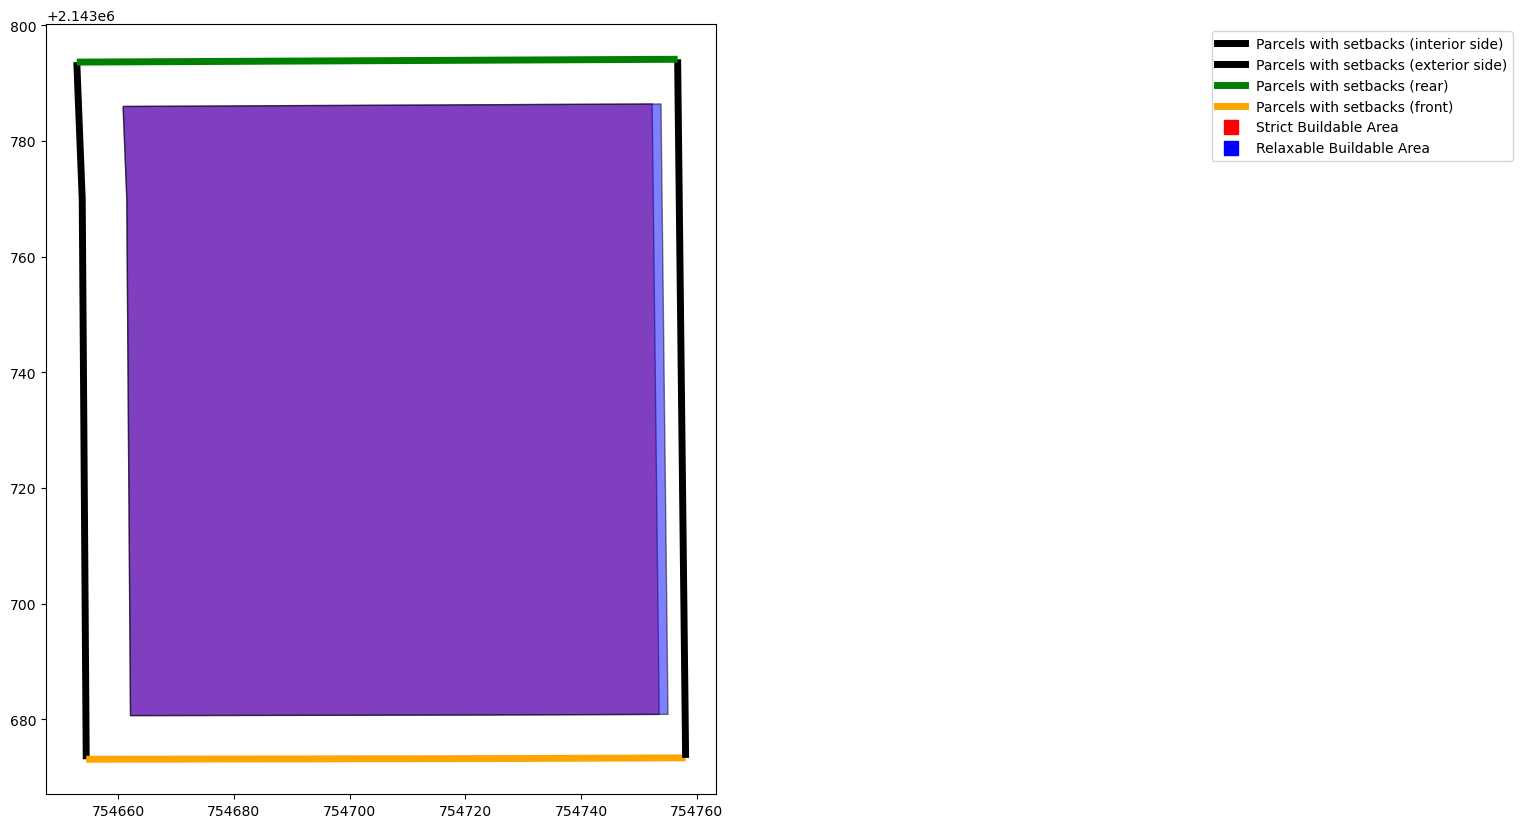

In [35]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define a mapping from 'side' values to colors.
color_mapping = {
    'Interior side': 'red',
    'Exterior side': 'blue',
    'rear': 'green',
    'front': 'orange'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the setbacks results by grouping based on the 'side' column.
for side, group in parcels_with_setbacks.groupby('side'):
    group.plot(
        ax=ax, 
        color=None, 
        alpha=1, 
        edgecolor=color_mapping.get(side, 'black'), 
        linewidth=5, 
        label=f'Parcels with setbacks ({side})'
    )

# Plot the strict buildable area.
strict_area = buildable_area.copy().set_geometry('buildable_geometry_strict')
strict_area.plot(
    ax=ax, 
    color='red', 
    alpha=0.5, 
    edgecolor='black', 
    label='Strict Buildable Area'
)

# Plot the relaxable buildable area.
relaxable_area = buildable_area.copy().set_geometry('buildable_geometry_relaxable')
relaxable_area.plot(
    ax=ax, 
    color='blue', 
    alpha=0.5, 
    edgecolor='black', 
    label='Relaxable Buildable Area'
)

# Create custom legend handles.
handles = []
# Add legend handles for each setbacks side.
for side in parcels_with_setbacks['side'].unique():
    color = color_mapping.get(side, 'black')
    handle = mlines.Line2D([], [], color=color, linewidth=5, label=f'Parcels with setbacks ({side})')
    handles.append(handle)
# Add handles for the buildable area layers.
handles.append(mlines.Line2D([], [], color='red', marker='s', markersize=10,
                             markerfacecolor='red', linestyle='None',
                             label='Strict Buildable Area'))
handles.append(mlines.Line2D([], [], color='blue', marker='s', markersize=10,
                             markerfacecolor='blue', linestyle='None',
                             label='Relaxable Buildable Area'))

ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(2.2, 1))
plt.show()

## `zp_check_fit` function
check whether the building footprint can fit into the parcel buildable_area.

In [36]:
zp_check_fit(buildable_area, vars)

,parcel_id,allowed
0,Dallas_County_combined_parcel_48828,True


## `zp_run_zoning_checks` function
check whether the building footprint can fit into the parcel buildable_area.

In [2]:
un_detailed_check = zp_run_zoning_checks(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg", 
                                         r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                                         r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                                         detailed_check=False,
                                         print_checkpoints=True,
                                         checks=possible_checks,
                                         save_to=None
                                         )

___data_prep___ 123.1s

___planned_dev_check___ 0.1s, kept 332626 parcels

___no_dist_check___ 0.1s, kept 332626 parcels

___get_zoning_req___ 873.5s

___initial_checks___ 8839.7s

___side_label_check___ 0.2s

___bldg_fit___ 383.7s

___overlay_check___ 0.0s

_____summary_____
total runtime: 10271.6s
604/366379 parcels allow the building; 7823/366379 maybe allow


In [3]:
detailed_check = zp_run_zoning_checks(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg", 
                                      r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                                      r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                                      detailed_check=True,
                                      print_checkpoints=True,
                                      checks=possible_checks,
                                      save_to=None
                                     )

___data_prep___ 92.8s

___planned_dev_check___ 0.0s, kept 474810 parcels

___no_dist_check___ 0.0s, kept 474810 parcels

___get_zoning_req___ 990.9s

___initial_checks___ 754.8s

___side_label_check___ 0.3s

___bldg_fit___ 19391.7s

___overlay_check___ 0.1s

_____summary_____
total runtime: 21234.2s
604/366379 parcels allow the building; 7823/366379 maybe allow


# Test for ReadMe

In [2]:
zoning_checks = zp_run_zoning_checks(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg", 
                                      r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1',
                                      r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1',
                                      checks=possible_checks,
                                     )

___data_prep___ 5.9s

___cross_no_dist_check___ 0.0s, kept 421 parcels

___get_zoning_req___ 1.2s

___initial_checks___ 1.1s

___side_label_check___ 0.0s

___bldg_fit___ 0.3s

_____summary_____
total runtime: 8.6s
0/421 parcels allow the building; 19/421 maybe allow


In [ ]:
# import pandas as pd
# import numpy as np

# # 如果你已经有 possible_checks，就用现成的；否则取消下一行的注释
# # possible_checks = ['res_type','unit_size','bldg_fit','overlay','far','fl_area','fl_area_first','fl_area_top','footprint','height','height_eave','lot_cov_bldg','lot_size','parking_enclosed','stories','unit_0bed','unit_1bed','unit_2bed','unit_3bed','unit_4bed','unit_density','unit_pct_0bed','unit_pct_1bed','unit_pct_2bed','unit_pct_3bed','unit_pct_4bed','total_units','unit_size_avg']

# def _norm_val(x):
#     """把各种取值规范成 'True' / 'MAYBE' / 'False' / 'NA'（仅用于统计）"""
#     if isinstance(x, str):
#         s = x.strip().upper()
#         if s in ("TRUE", "FALSE"):
#             return "True" if s == "TRUE" else "False"
#         if s == "MAYBE":
#             return "MAYBE"
#     if pd.isna(x):
#         return "NA"
#     if x is True:
#         return "True"
#     if x is False:
#         return "False"
#     # 兜底：把其他类型转成字符串（极少见）
#     return str(x)

# def summarize_checks(df, checks, include_na=False):
#     """
#     对 checks 列做统计，返回每个检查的 True/MAYBE/False 计数以及百分比。
#     include_na=True 时会额外给出 NA 计数。
#     """
#     use_cols = [c for c in checks if c in df.columns]
#     if not use_cols:
#         raise ValueError("None of the requested checks are present in the DataFrame.")

#     # 统一规范值，然后“熔化”为长表便于 groupby 统计
#     normed = df[use_cols].applymap(_norm_val)
#     long = normed.stack().reset_index()
#     long.columns = ["row_id", "check", "value"]

#     # 只统计我们关心的三类；NA 可选
#     wanted = ["True", "MAYBE", "False"]
#     if include_na:
#         wanted = wanted + ["NA"]

#     counts = (
#         long[long["value"].isin(wanted)]
#         .groupby(["check", "value"])
#         .size()
#         .unstack(fill_value=0)
#         .reindex(columns=wanted, fill_value=0)       # 固定列顺序
#         .reindex(index=checks, fill_value=0)         # 按 possible_checks 顺序排列
#     )

#     # 百分比（分母不含 NA）
#     denom = counts[["True", "MAYBE", "False"]].sum(axis=1).replace(0, np.nan)
#     pct = counts[["True", "MAYBE", "False"]].div(denom, axis=0).mul(100).round(1)
#     pct.columns = [f"{c}_pct" for c in pct.columns]

#     out = counts.join(pct)
#     return out

# # —— 使用示例 ——
# summary = summarize_checks(zoning_checks, possible_checks, include_na=False)
# summary  # 在 notebook 里会直接显示表格


/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_31328/3438317228.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  normed = df[use_cols].applymap(_norm_val)


,True,MAYBE,False,True_pct,MAYBE_pct,False_pct
check,,,,,,
res_type,65,0,356,15.4,0.0,84.6
unit_size,421,0,0,100.0,0.0,0.0
bldg_fit,205,35,11,81.7,13.9,4.4
overlay,0,0,0,NaN,NaN,NaN
far,421,0,0,100.0,0.0,0.0
fl_area,421,0,0,100.0,0.0,0.0
fl_area_first,421,0,0,100.0,0.0,0.0
fl_area_top,421,0,0,100.0,0.0,0.0
footprint,421,0,0,100.0,0.0,0.0


In [ ]:
# import geopandas as gpd
# from shapely.ops import unary_union, polygonize
# import numpy as np

# district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/Paradise.zoning", trans_crs=None)
# parcels = zp_read_pcl(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/Paradise.parcel", district)

# parcels_Paradise = parcels.copy()
# parcels_Paradise = parcels_Paradise[parcels_Paradise['side'] != 'centroid']


# parcels_poly = (
#     parcels_Paradise[['parcel_id', 'geometry']]
#       .explode(index_parts=False)
#       .dissolve(by='parcel_id')
#       .assign(geometry=lambda df: df.geometry.apply(
#           lambda g: max(list(polygonize(g)), key=lambda p: p.area)
#       ))
#       .reset_index()
# )

# parcels_poly = parcels_poly.merge(zoning_checks[['parcel_id','muni_name','dist_abbr','allowed']], on='parcel_id', how='left')
# parcels_poly

,parcel_id,geometry,muni_name,dist_abbr,allowed
0,Wise_County_combined_parcel_1,"POLYGON ((674992.353 2165003.612, 674996.794 2...",[Paradise],[R-1],False
1,Wise_County_combined_parcel_10300,"POLYGON ((675172.112 2165368.064, 675175.230 2...",[Paradise],[R-1],False
2,Wise_County_combined_parcel_10450,"POLYGON ((675222.632 2164100.864, 675135.728 2...",[Paradise],[R-1],False
3,Wise_County_combined_parcel_10451,"POLYGON ((675434.098 2164306.727, 675433.907 2...",[Paradise],[R-1],False
4,Wise_County_combined_parcel_10452,"POLYGON ((675436.034 2164459.051, 675435.681 2...",[Paradise],[R-1],False
...,...,...,...,...,...
416,Wise_County_combined_parcel_9383,"POLYGON ((675901.032 2164623.478, 675864.398 2...",[Paradise],[R-2],MAYBE
417,Wise_County_combined_parcel_9384,"POLYGON ((675939.987 2164703.091, 675940.012 2...",[Paradise],[B-1],False
418,Wise_County_combined_parcel_9385,"POLYGON ((675908.352 2164764.109, 675944.931 2...",[Paradise],[B-1],False
419,Wise_County_combined_parcel_9463,"POLYGON ((675190.621 2165626.004, 675212.600 2...",[Paradise],[R-1],False


In [5]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import contextily as cx

# if 'allowed' not in parcels_poly.columns and 'allowed' in parcels_Paradise.columns:
#     attrs = parcels_Paradise[['parcel_id','allowed']].drop_duplicates('parcel_id')
#     parcels_poly = parcels_poly.merge(attrs, on='parcel_id', how='left')

# gdf3857 = parcels_poly.to_crs(3857)
# xmin, ymin, xmax, ymax = gdf3857.total_bounds   

# fig, ax = plt.subplots(figsize=(16, 12), dpi=150)

# gdf3857.plot(
#     ax=ax,
#     column='allowed',
#     categorical=True,
#     legend=True,
#     alpha=1,
#     edgecolor="black",
#     linewidth=0.6,
#     zorder=3,
#     legend_kwds={'frameon': False, 'loc': 'upper left', 'bbox_to_anchor': (-0.03, 1.0)},
# )

# cx.add_basemap(
#     ax,
#     crs=gdf3857.crs,
#     source=cx.providers.CartoDB.Positron,
#     zoom=15,
#     zorder=1,
#     reset_extent=False
# )

# pad = 0.02 * max(xmax - xmin, ymax - ymin)
# ax.set_xlim(xmin - pad, xmax + pad)
# ax.set_ylim(ymin - pad, ymax + pad)

# ax.set_aspect("equal")
# ax.set_axis_off()
# plt.tight_layout()

# fig.savefig("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/README_zoning_checks_3.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
# plt.show()

In [3]:
district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/Paradise.zoning", trans_crs=None)
parcels = zp_read_pcl(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/Paradise.parcel", district)

In [4]:
parcels[parcels['parcel_id'] == 'Wise_County_combined_parcel_37980']

,parcel_id,side,lot_width,lot_depth,lot_area,geometry,zoning_id
1422,Wise_County_combined_parcel_37980,interior side,NaN,NaN,NaN,"LINESTRING (675881.376 2164547.706, 675983.704...",NaN
1423,Wise_County_combined_parcel_37980,rear,NaN,NaN,NaN,"LINESTRING (675883.229 2164490.798, 675881.376...",NaN
1424,Wise_County_combined_parcel_37980,interior side,NaN,NaN,NaN,"LINESTRING (675985.336 2164491.232, 675883.229...",NaN
1425,Wise_County_combined_parcel_37980,front,NaN,NaN,NaN,"LINESTRING (675983.704 2164549.121, 675985.336...",NaN
1426,Wise_County_combined_parcel_37980,centroid,189.730323,335.274263,1.446077,POINT (675933.556 2164519.727),8


In [24]:
district

,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Agricultural,A,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['2']...,"MULTIPOLYGON (((675992.013 2163963.896, 675957...",0
1,Single-Family Residential,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.1...,"MULTIPOLYGON (((675744.282 2164683.758, 675707...",1
2,Multifamily Residential,R-2,False,False,"[1_unit, 2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['0.1...,"MULTIPOLYGON (((675649.123 2164591.909, 675612...",2
5,General Business,B-1,False,False,NaN,{'lot_size': {'min_val': [{'expression': ['0.1...,"MULTIPOLYGON (((675796.061 2164115.593, 675876...",5
6,Manufacturing/Industrial - Light,I-1,False,False,NaN,NaN,"MULTIPOLYGON (((676145.022 2163749.328, 676051...",6
7,Manufacturing/Industrial - Heavy,I-2,False,False,NaN,NaN,"POLYGON ((675217.485 2166119.536, 675128.858 2...",7
8,Mixed-Use,MU,False,False,NaN,NaN,"POLYGON ((675881.332 2164549.067, 675775.919 2...",8


In [5]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg")
district_data = district[district['dist_name']=='Mixed-Use']
parcel_dim = zp_get_parcel_dim(parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Wise_County_combined_parcel_37980']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Paradise.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)

parcel_geo = zp_get_parcel_geo(parcels)
parcel_geo_data = parcel_geo[parcel_geo['parcel_id'] == 'Wise_County_combined_parcel_37980']
parcels_with_setbacks = zp_add_setbacks(parcel_geo_data, district_data, zoning_req)
buildable_area = zp_get_buildable_area(parcels_with_setbacks)
buildable_area

,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,Wise_County_combined_parcel_37980,"POLYGON ((675881.3763568803 2164547.706334737,...","POLYGON ((675881.376 2164547.706, 675983.704 2..."


In [57]:
import geopandas as gpd
from folium import LayerControl

m = parcel_geo_data.explore(
    name="Parcels",                
    color="blue",               
    style_kwds=dict(
        fillColor="blue",       
        fillOpacity=0.2, 
        weight=3
    ),
    tooltip=True,                     
)

district_data.explore(
    m=m,                            
    name="Districts",
    color="red",
    style_kwds=dict(
        fillColor="red",
        fillOpacity=0.5,            
        weight=1
    ),
    tooltip=True
)

LayerControl(collapsed=False).add_to(m)

m

# m.save("parcel_district_map.html")

In [67]:
parcel_geo_data.to_file((r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1/parcel_geo_data.geojson"))

# Debug Processing

In [1]:
import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping
import os
import json
import glob

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks

In [13]:
bldg_file = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg"
zoning_files = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1"
parcel_files = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test_1"

start_time = time.time()

# ————————— 0. Parameter validation ————————— #
# 1. Validate checks input parameter
checks = possible_checks.copy()

# 2. Determine initial constraints to run (excluding built-in res_type/unit_size/bldg_fit/overlay)
initial_checks = [
    c for c in checks
    if c not in ("res_type", "unit_size", "bldg_fit", "overlay")
]

# 3. Process zoning_files: support single file or directory
if isinstance(zoning_files, str):
    if os.path.isdir(zoning_files):
        zoning_files = glob.glob(os.path.join(zoning_files, "*.zoning"))
    else:
        zoning_files = [zoning_files]

# 4. Process parcel_files: same as above
if isinstance(parcel_files, str):
    if os.path.isdir(parcel_files):
        parcel_files = glob.glob(os.path.join(parcel_files, "*.parcel"))
    else:
        parcel_files = [parcel_files]

# ————————— 1. Data preparation ————————— #
# 1. Read building JSON
bldg_data = zp_read_bldg(bldg_file)

# 2. Read zoning layers and corresponding JSON
zoning_gdfs = []
zoning_jsons = []

first = True
target_crs = None
for muni_id, zf in enumerate(zoning_files):
    gz = zp_read_dist(zf)
    if first:
        target_crs = gz.crs
        first = False
    else:
        gz = gz.to_crs(target_crs)
    with open(zf, "r") as f:
        js = json.load(f)
    gz["muni_name"] = js.get("muni_name")  
    gz["muni_id"] = muni_id
    zoning_gdfs.append(gz)
    zoning_jsons.append(js)
zoning_all = pd.concat(zoning_gdfs, ignore_index=True)
zoning_all
# 3. Create unique zoning_id by combining muni_id and original zoning_id
zoning_all['zoning_id'] = (zoning_all['muni_id'].astype(int).astype(str) + '_' + zoning_all['zoning_id'].astype(int).astype(str))

# 4. Separate into overlays, planned_dev districts, and base zones
overlays = zoning_all[zoning_all["overlay"] == True]
pd_districts = zoning_all[zoning_all["planned_dev"] == True]
base_zones  = zoning_all[(zoning_all["overlay"] == False) & (zoning_all["planned_dev"]== False)]

# 5. Read parcels and assign base zoning IDs
parcel_list = [ zp_read_pcl(p, base_zones) for p in parcel_files ]
parcels_sf = pd.concat(parcel_list, ignore_index=True)
# 6. Generate parcel_geo with 'side' labels
parcel_geo  = zp_get_parcel_geo(parcels_sf)
# 7. Generate parcel_dims with centroid and dimensions, rename zoning_id to muni_base_id
parcel_dims = zp_get_parcel_dim(parcels_sf)
parcel_dims = parcel_dims.rename(columns={"zoning_id":"muni_base_id"})

# 8. Add muni_pd_id and muni_overlay_id
pd_idx = zp_find_district_idx(parcel_dims, pd_districts).rename(columns={"zoning_id":"muni_pd_id"})
ov_idx = zp_find_district_idx(parcel_dims, overlays).rename(columns={"zoning_id":"muni_overlay_id"})
parcel_dims = parcel_dims.merge(pd_idx[["parcel_id","muni_pd_id"]], on='parcel_id', how="left")
parcel_dims = parcel_dims.merge(ov_idx[["parcel_id","muni_overlay_id"]], on='parcel_id', how="left")
parcel_dims = parcel_dims.drop_duplicates(keep='first').reset_index(drop=True)

# 9. Add dist_abbr and muni_name for all zone IDs
dist_abbr_map = zoning_all.set_index("zoning_id")["dist_abbr"].to_dict()
muni_name_map = zoning_all.set_index("zoning_id")["muni_name"].to_dict()
def collect_all(ids, mapping):
    vals = []

    def handle_one(zid):
        if pd.isna(zid):
            return
        v = mapping.get(zid)
        if isinstance(v, (list, tuple)):
            vals.extend(v)
        elif v is not None:
            vals.append(v)

    for z_id in ids:
        if isinstance(z_id, (list, tuple)):
            for sub_id in z_id:
                handle_one(sub_id)
        else:
            handle_one(z_id)

    seen = set()
    uniq = []
    for v in vals:
        if v not in seen:
            seen.add(v)
            uniq.append(v)
    return uniq

parcel_dims["all_zone_ids"] = parcel_dims[[
    "muni_base_id","muni_pd_id","muni_overlay_id"
]].values.tolist()

parcel_dims["dist_abbr"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, dist_abbr_map))
parcel_dims["muni_name"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, muni_name_map))

# 10. Initialize false_reasons and maybe_reasons columns
parcel_dims["false_reasons"] = None
parcel_dims["maybe_reasons"] = None
false_dfs = []
maybe_dfs = []

elapsed = time.time() - start_time
print(f"___data_prep___ {elapsed:.1f}s\n")

detailed_check = True

# ————————— 2. Planned Development check ————————— #
t0 = time.time()
if not pd_districts.empty:
    # Identify parcels in planned development districts via muni_pd_id
    pd_parcels = pd_idx["parcel_id"][pd_idx["muni_pd_id"].notna()]
    # Mark these parcels as FALSE and record the reason
    mask_pd = parcel_dims["parcel_id"].isin(pd_parcels)
    parcel_dims.loc[mask_pd, "false_reasons"] = (
        parcel_dims.loc[mask_pd, "false_reasons"]
        .fillna("") .apply(lambda s: "PD_dist" if s=="" else s+",PD_dist")
    )
    # Add intermediate variable check_pd for detailed_check logic
    parcel_dims["check_pd"] = ~mask_pd
    
if not detailed_check:
    df0 = parcel_dims[ mask_pd ]
    false_dfs.append(df0)
    parcel_dims = parcel_dims[~mask_pd]

print(f"___planned_dev_check___ {time.time()-t0:.1f}s, kept {parcel_dims.shape[0]} parcels\n")

___data_prep___ 17.8s

___planned_dev_check___ 0.0s, kept 47712 parcels



In [14]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,muni_overlay_id,all_zone_ids,dist_abbr,muni_name,false_reasons,maybe_reasons,check_pd
0,Collin_County_combined_parcel_125997,1.000000,1.000000,3.026274,regular,no,centroid,POINT (773814.800 2147738.998),0_0,NaN,NaN,"[0_0, nan, nan]",[AG],[Garland],None,None,True
1,Dallas_County_combined_parcel_10001,62.904205,113.327637,0.163654,regular,yes,centroid,POINT (770327.109 2145999.252),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
2,Dallas_County_combined_parcel_10002,1.000000,1.000000,0.217468,regular,no,centroid,POINT (770364.223 2145995.727),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
3,Dallas_County_combined_parcel_10005,1.000000,1.000000,0.212473,regular,no,centroid,POINT (771163.408 2145984.640),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
4,Dallas_County_combined_parcel_10007,57.203545,116.226935,0.150086,regular,yes,centroid,POINT (771109.167 2145977.198),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,Dallas_County_combined_parcel_9993,69.509165,132.072797,0.189133,regular,yes,centroid,POINT (770186.186 2146012.876),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47708,Dallas_County_combined_parcel_9995,62.904458,113.327481,0.163654,regular,yes,centroid,POINT (770086.360 2146016.477),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47709,Dallas_County_combined_parcel_9997,63.472930,114.929293,0.164013,regular,yes,centroid,POINT (770698.388 2146004.259),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47710,Dallas_County_combined_parcel_9998,80.108446,114.825290,0.178343,regular,yes,centroid,POINT (770639.296 2146013.652),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True


In [15]:
# ————————— 3. District checks ————————— #
t1 = time.time()
# 2. Warn about parcels not covered by any district
mask_dist_cover = (parcel_dims["muni_base_id"].isna() & parcel_dims["muni_pd_id"].isna() & parcel_dims["muni_overlay_id"].isna())
missing = parcel_dims.loc[mask_dist_cover, "parcel_id"]
if not missing.empty:
    # Append 'no_district' to maybe_reasons
    parcel_dims.loc[mask_dist_cover, "maybe_reasons"] = (
        parcel_dims.loc[mask_dist_cover, "maybe_reasons"]
        .fillna("")  # None -> ""
        .apply(lambda s: "no_district" if s == "" else s + ",no_district")
    )
    # Add intermediate variable check_dist_cover for detailed_check logic
    parcel_dims["check_dist_cover"] = ~mask_dist_cover

# Handle cross-base and no-district cases
if not detailed_check:
    df_dist = parcel_dims.loc[mask_dist_cover]
    maybe_dfs.append(df_dist)
    parcel_dims = parcel_dims.loc[~mask_dist_cover]

print(f"___dist_cross_cover_check___ {time.time()-t1:.1f}s, kept {parcel_dims.shape[0]} parcels\n")

___dist_cross_cover_check___ 0.0s, kept 47712 parcels



In [16]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,muni_overlay_id,all_zone_ids,dist_abbr,muni_name,false_reasons,maybe_reasons,check_pd
0,Collin_County_combined_parcel_125997,1.000000,1.000000,3.026274,regular,no,centroid,POINT (773814.800 2147738.998),0_0,NaN,NaN,"[0_0, nan, nan]",[AG],[Garland],None,None,True
1,Dallas_County_combined_parcel_10001,62.904205,113.327637,0.163654,regular,yes,centroid,POINT (770327.109 2145999.252),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
2,Dallas_County_combined_parcel_10002,1.000000,1.000000,0.217468,regular,no,centroid,POINT (770364.223 2145995.727),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
3,Dallas_County_combined_parcel_10005,1.000000,1.000000,0.212473,regular,no,centroid,POINT (771163.408 2145984.640),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
4,Dallas_County_combined_parcel_10007,57.203545,116.226935,0.150086,regular,yes,centroid,POINT (771109.167 2145977.198),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,Dallas_County_combined_parcel_9993,69.509165,132.072797,0.189133,regular,yes,centroid,POINT (770186.186 2146012.876),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47708,Dallas_County_combined_parcel_9995,62.904458,113.327481,0.163654,regular,yes,centroid,POINT (770086.360 2146016.477),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47709,Dallas_County_combined_parcel_9997,63.472930,114.929293,0.164013,regular,yes,centroid,POINT (770698.388 2146004.259),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True
47710,Dallas_County_combined_parcel_9998,80.108446,114.825290,0.178343,regular,yes,centroid,POINT (770639.296 2146013.652),0_3,NaN,NaN,"[0_3, nan, nan]",[SF-7],[Garland],None,None,True


In [19]:
# ————————— 4. Variables & requirements ————————— #
t2 = time.time()
vars_map = {}
req_map  = {}
no_setback = set()

def safe_sum(x):
    """
    Safely sum a value that may be None, NaN, or a list/tuple containing None/NaN.
    - None or NaN are treated as 0.
    - Lists/tuples are filtered of None/NaN before summing.
    """
    # Treat None or NaN as 0
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    # If list or tuple, filter out None/NaN and sum
    if isinstance(x, (list, tuple)):
        return sum(i for i in x if i is not None and not (isinstance(i, float) and np.isnan(i)))
    # Otherwise, return the numeric value directly
    return x

for idx in parcel_dims.index:
    # Extract a one-row DataFrame (keeps column types) instead of a Series
    parcel_data = parcel_dims.loc[[idx]]
    pid = parcel_data.at[idx, "parcel_id"]
    # Build list of zoning IDs (may be a single ID or a list)
    ids = (parcel_data.at[idx, "muni_base_id"]
        if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
        else [parcel_data.at[idx, "muni_base_id"]])
    # Subset zoning_all by those IDs
    dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
    # Skip if there isn’t exactly one matching district
    if dist_df.shape[0] != 1:
        continue
    # Load that municipality’s JSON definitions
    muni_id = int(dist_df.iloc[0]["muni_id"])
    munijson = zoning_jsons[muni_id]["definitions"]
    # Compute variables and zoning requirements
    v = zp_get_variables(bldg_data, parcel_data, dist_df, munijson)
    z = zp_get_zoning_req(dist_df, bldg_data=None, parcel_data=None, zoning_data=None, vars=v)
    vars_map[pid] = v
    req_map[pid]  = z
    # Identify parcels with no setback requirements
    if isinstance(z, str):
        # If z is an error string, treat as no setbacks
        no_setback.add(pid)
    else:
        # Filter constraints containing “setback”
        sb = z[z["constraint_name"].str.contains("setback")]["min_value"]
        # If all are NaN or their safe sum is zero, mark as no setback
        if sb.isnull().all() or sb.apply(safe_sum).sum() == 0:
            no_setback.add(pid)
print(f"___get_zoning_req___ {time.time()-t2:.1f}s\n")

___get_zoning_req___ 126.5s



In [20]:
# ————————— 5. Initial checks (res_type, constraints, unit_size) ————————— #
t3 = time.time()
init_results = {}
for idx in parcel_dims.index:
    parcel_data = parcel_dims.loc[[idx]]
    pid = parcel_data.at[idx, "parcel_id"]
    ids = (parcel_data.at[idx, "muni_base_id"]
        if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
        else [parcel_data.at[idx, "muni_base_id"]])
    dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
    # Skip if there isn’t exactly one matching district
    if dist_df.shape[0] != 1:
        continue
    v   = vars_map[pid]
    z   = req_map[pid]

    # 1) Residential type check
    if "res_type" in checks:
        rt_ok = zp_check_res_type(v, dist_df)
        df_rt = pd.DataFrame({"res_type":[rt_ok]})
    else:
        df_rt = pd.DataFrame()

    # 2) Other quantitative constraints
    try:
        df_cons = zp_check_constraints(v, z, checks=initial_checks)
    except:
        df_cons = pd.DataFrame()
    if not df_cons.empty:
        df_c = df_cons.set_index("constraint_name")["allowed"].to_frame().T
    else:
        df_c = pd.DataFrame()

    # 3) Unit size check
    if "unit_size" in checks:
        u_ok = zp_check_unit(dist_df, bldg_data, v)
        df_u = pd.DataFrame({"unit_size":[u_ok]})
    else:
        df_u = pd.DataFrame()

    # Combine results into one DataFrame
    merged = pd.concat([df_rt, df_c.reset_index(drop=True), df_u], axis=1)
    merged.index = [idx]
    init_results[idx] = merged

    # Record reasons for FALSE/MAYBE
    vals = merged.iloc[0].astype(str)
    fals = vals[vals=="False"].index.tolist()
    mays = vals[vals=="MAYBE"].index.tolist()
    if fals:
        s = parcel_dims.at[idx,"false_reasons"] or ""
        parcel_dims.at[idx,"false_reasons"] = (",".join(fals) if s=="" else s + "," + ",".join(fals))
    if mays:
        s = parcel_dims.at[idx,"maybe_reasons"] or ""
        parcel_dims.at[idx,"maybe_reasons"] = (",".join(mays)if s=="" else s + "," + ",".join(mays))

    # If FALSE and not detailed_check, remove parcel to false_dfs
    if ("False" in vals.values) and (not detailed_check):
        false_dfs.append(parcel_dims.loc[[idx]])
        parcel_dims.drop(idx, inplace=True)

# Concatenate all individual results into one DataFrame, preserving original idx as index
init_df = pd.concat(init_results, axis=0)
# init_df now has a two-level index; drop the first level (original idx)
init_df.index = init_df.index.droplevel(0)
# Treat NA as True (matching R behavior)
init_df = init_df.fillna(True)
# Join init_df back to parcel_dims aligned by index
parcel_dims = parcel_dims.join(init_df)

print(f"___initial_checks___ {time.time()-t3:.1f}s\n")

___initial_checks___ 147.8s



In [21]:
# ————————— 6. Side label check ————————— #
if "bldg_fit" in checks and not parcel_dims.empty:
    t4 = time.time()
    known = set(parcel_geo.loc[parcel_geo["side"]!="unknown","parcel_id"])
    keep = known.union(no_setback)
    # Mark parcel_side_lbl flag
    parcel_dims["parcel_side_lbl"] = parcel_dims["parcel_id"].isin(keep)
    # Parcels without side label get MAYBE reason
    mask = ~parcel_dims["parcel_side_lbl"]
    parcel_dims.loc[mask, "maybe_reasons"] = (
        parcel_dims.loc[mask, "maybe_reasons"]
        .fillna("") .apply(lambda s: "side_lbl" if s=="" else s+",side_lbl")
    )
    # If not detailed_check, remove them to false_dfs
    if not detailed_check:
        false_dfs.append(parcel_dims[mask])
        parcel_dims = parcel_dims[~mask]
print(f"___side_label_check___ {time.time()-t4:.1f}s\n")

___side_label_check___ 0.0s



In [22]:
# ————————— 7. Building fit check ————————— #
parcel_dims["bldg_fit"] = None
parcel_dims["bldg_fit"] = parcel_dims["bldg_fit"].astype(object)

if "bldg_fit" in checks and not parcel_dims.empty:
    t5 = time.time()
    for idx in parcel_dims.index:
        if not parcel_dims.at[idx, "parcel_side_lbl"]:
            continue
        pid = parcel_dims.at[idx, "parcel_id"]
        sides = parcel_geo[parcel_geo["parcel_id"] == pid]
        if sides.empty:
            continue
        base_ids = parcel_dims.at[idx, "muni_base_id"]
        if not isinstance(base_ids, (list, tuple)):
            base_ids = [base_ids]
        dist_df = zoning_all[zoning_all["zoning_id"].isin(base_ids)]
        # Skip if there isn’t exactly one matching district
        if dist_df.shape[0] != 1:
            continue
        v   = vars_map[pid]
        z   = req_map[pid]
        pg_sb = zp_add_setbacks(sides, dist_df, z)
        bz    = zp_get_buildable_area(pg_sb)
        fitdf = zp_check_fit(bz, v)
        ok = fitdf.loc[0,"allowed"]
        parcel_dims.at[idx,"bldg_fit"] = ok
        if ok=="MAYBE":
            s = parcel_dims.at[idx,"maybe_reasons"] or ""
            parcel_dims.at[idx,"maybe_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
        if ok==False:
            s = parcel_dims.at[idx,"false_reasons"] or ""
            parcel_dims.at[idx,"false_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
    if not detailed_check:
        mask = parcel_dims["bldg_fit"]==False
        false_dfs.append(parcel_dims[mask])
        parcel_dims = parcel_dims[~mask]
print(f"___bldg_fit___ {time.time()-t5:.1f}s\n")

___bldg_fit___ 355.9s



In [23]:
# ————————— 8. Overlay check ————————— #
if "overlay" in checks and not overlays.empty:
    t6 = time.time()
    def has_overlay(val):
        if isinstance(val, (list, tuple)):
            return any(pd.notna(x) for x in val)
        return pd.notna(val)
    mask = parcel_dims["muni_overlay_id"].apply(has_overlay)
    parcel_dims.loc[mask, "maybe_reasons"] = (
        parcel_dims.loc[mask, "maybe_reasons"]
        .fillna("")
        .apply(lambda s: "overlay" if s == "" else s + ",overlay")
    )

In [24]:
# ————————— 9. Merge & output ————————— #
# Concatenate all parcels removed to false_dfs plus those still in parcel_dims
final = pd.concat(false_dfs + maybe_dfs + [parcel_dims], ignore_index=True)

In [25]:
# Immediately deduplicate after summarize() to avoid identical rows entering subsequent steps
final["_geom_wkb"] = final.geometry.apply(lambda g: g.wkb if g is not None else None)
final = final.drop_duplicates(
    subset=[c for c in ["parcel_id","false_reasons","maybe_reasons","_geom_wkb"] if c in final.columns],
    keep="first"
)
final = final.drop(columns=["_geom_wkb"])
final = final.reset_index(drop=True)

In [26]:
# Compute allowed & reason columns
def summarize(r):
    fr = r.get("false_reasons") or ""
    mr = r.get("maybe_reasons") or ""
    if fr: return (False, fr)
    if mr: return ("MAYBE", mr)
    return (True, "Building allowed")

final[["allowed","reason"]] = pd.DataFrame(
    final.apply(summarize, axis=1).tolist(),
    index=final.index
)
final

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,total_units,unit_size_avg,parcel_side_lbl,bldg_fit,allowed,reason
0,Collin_County_combined_parcel_125997,1.000000,1.000000,3.026274,regular,no,centroid,POINT (773814.800 2147738.998),0_0,NaN,...,True,True,True,True,True,True,False,None,False,"res_type,height"
1,Dallas_County_combined_parcel_10001,62.904205,113.327637,0.163654,regular,yes,centroid,POINT (770327.109 2145999.252),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"
2,Dallas_County_combined_parcel_10002,1.000000,1.000000,0.217468,regular,no,centroid,POINT (770364.223 2145995.727),0_3,NaN,...,True,True,True,True,True,True,False,None,False,"res_type,height"
3,Dallas_County_combined_parcel_10005,1.000000,1.000000,0.212473,regular,no,centroid,POINT (771163.408 2145984.640),0_3,NaN,...,True,True,True,True,True,True,False,None,False,"res_type,height"
4,Dallas_County_combined_parcel_10007,57.203545,116.226935,0.150086,regular,yes,centroid,POINT (771109.167 2145977.198),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47704,Dallas_County_combined_parcel_9993,69.509165,132.072797,0.189133,regular,yes,centroid,POINT (770186.186 2146012.876),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"
47705,Dallas_County_combined_parcel_9995,62.904458,113.327481,0.163654,regular,yes,centroid,POINT (770086.360 2146016.477),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"
47706,Dallas_County_combined_parcel_9997,63.472930,114.929293,0.164013,regular,yes,centroid,POINT (770698.388 2146004.259),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"
47707,Dallas_County_combined_parcel_9998,80.108446,114.825290,0.178343,regular,yes,centroid,POINT (770639.296 2146013.652),0_3,NaN,...,True,True,True,True,True,True,True,True,False,"res_type,height"


In [ ]:
final["is_duplicate"] = final.duplicated(subset=["parcel_id"], keep=False)

In [44]:
# Select output columns based on detailed_check
if not detailed_check:
    out = final[[
        "parcel_id","muni_name","dist_abbr","allowed","reason","geometry","is_duplicate"
    ]].copy()
else:
    drop_cols = [
        "false_reasons","maybe_reasons",
        "lot_width","lot_depth","lot_area","lot_type",
        "muni_base_id","muni_pd_id","muni_overlay_id",
    ]
    keep = [c for c in final.columns if c not in drop_cols]
    out = final[keep].copy()
out

# dups = out["parcel_id"][out["parcel_id"].duplicated()].unique()
# if len(dups)>0:
#     merged = []
#     for pid in dups:
#         sub = out[out["parcel_id"]==pid]
#         vals = sub["allowed"].tolist()
#         if all(v==True for v in vals):
#             v = True
#         elif all(v==False for v in vals):
#             v = False
#         else:
#             v = "MAYBE"
#         reasons = " ---||--- ".join(sub["reason"].tolist())
#         row = sub.iloc[0].copy()
#         row["allowed"] = v
#         row["reason"]  = reasons
#         merged.append(row)
#     out = out[~out["parcel_id"].isin(dups)].append(merged, ignore_index=True)
# out

,parcel_id,conf,side,geometry,all_zone_ids,dist_abbr,muni_name,check_pd,res_type,lot_cov_bldg,...,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,total_units,unit_size_avg,parcel_side_lbl,bldg_fit,allowed,reason,is_duplicate
0,Collin_County_combined_parcel_125997,no,centroid,POINT (773814.800 2147738.998),"[0_0, nan, nan]",[AG],[Garland],True,False,True,...,True,True,True,True,True,False,None,False,"res_type,height",False
1,Dallas_County_combined_parcel_10001,yes,centroid,POINT (770327.109 2145999.252),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False
2,Dallas_County_combined_parcel_10002,no,centroid,POINT (770364.223 2145995.727),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,False,None,False,"res_type,height",False
3,Dallas_County_combined_parcel_10005,no,centroid,POINT (771163.408 2145984.640),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,False,None,False,"res_type,height",False
4,Dallas_County_combined_parcel_10007,yes,centroid,POINT (771109.167 2145977.198),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47704,Dallas_County_combined_parcel_9993,yes,centroid,POINT (770186.186 2146012.876),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False
47705,Dallas_County_combined_parcel_9995,yes,centroid,POINT (770086.360 2146016.477),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False
47706,Dallas_County_combined_parcel_9997,yes,centroid,POINT (770698.388 2146004.259),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False
47707,Dallas_County_combined_parcel_9998,yes,centroid,POINT (770639.296 2146013.652),"[0_3, nan, nan]",[SF-7],[Garland],True,False,True,...,True,True,True,True,True,True,True,False,"res_type,height",False


# Debug the final result

In [48]:
kamryn_results = gpd.read_file(r'/Users/houpuli/Downloads/five_city_test_output.geojson')
kamryn_results

,parcel_id,muni_name,dist_abbr,allowed,reason,is_duplicate,geometry
0,Collin_County_combined_parcel_101352,Dalals,PD,FALSE,PD_dist,False,POINT (-96.75904 32.99330)
1,Collin_County_combined_parcel_102175,Dalals,PD,FALSE,PD_dist,False,POINT (-96.76041 32.99347)
2,Collin_County_combined_parcel_103928,Dalals,PD,FALSE,PD_dist,False,POINT (-96.83514 33.00652)
3,Collin_County_combined_parcel_104581,Dalals,PD,FALSE,PD_dist,False,POINT (-96.83434 33.00598)
4,Collin_County_combined_parcel_105806,Dalals,PD,FALSE,PD_dist,False,POINT (-96.76129 32.99257)
...,...,...,...,...,...,...,...
45262,Dallas_County_combined_parcel_683258,Garland,DT,TRUE,Building allowed,False,POINT (-96.64168 32.90930)
45263,Dallas_County_combined_parcel_683279,Garland,DT,TRUE,Building allowed,False,POINT (-96.64304 32.91067)
45264,Dallas_County_combined_parcel_683699,Garland,DT,TRUE,Building allowed,False,POINT (-96.64533 32.91203)
45265,Dallas_County_combined_parcel_690833,Garland,DT,TRUE,Building allowed,False,POINT (-96.63573 32.91016)


In [49]:
kamryn_results_parcel_list = kamryn_results['parcel_id'].unique()
houpu_un_detailed_check = un_detailed_check[un_detailed_check['parcel_id'].isin(kamryn_results_parcel_list)]
houpu_un_detailed_check

,parcel_id,muni_name,dist_abbr,allowed,reason,geometry,is_duplicate
22,Collin_County_combined_parcel_101352,[Dalals],"[PD, Dallas_PD_Subdistricts]",False,PD_dist,POINT (762683.277 2148457.842),False
29,Collin_County_combined_parcel_102175,[Dalals],"[PD, Dallas_PD_Subdistricts]",False,PD_dist,POINT (762554.286 2148474.914),False
47,Collin_County_combined_parcel_103928,[Dalals],[PD],False,PD_dist,POINT (755549.639 2149809.066),False
55,Collin_County_combined_parcel_104581,[Dalals],[PD],False,PD_dist,POINT (755624.675 2149749.858),False
70,Collin_County_combined_parcel_105806,[Dalals],"[PD, Dallas_PD_Subdistricts]",False,PD_dist,POINT (762474.459 2148373.951),False
...,...,...,...,...,...,...,...
366370,Dallas_County_combined_parcel_683279,[Garland],[DT],True,Building allowed,POINT (773683.484 2139482.064),False
366371,Dallas_County_combined_parcel_683699,[Garland],[DT],True,Building allowed,POINT (773466.628 2139629.964),False
366375,Dallas_County_combined_parcel_690833,[Garland],[DT],True,Building allowed,POINT (774367.719 2139438.136),False
366376,Dallas_County_combined_parcel_691069,[Garland],[DT],True,Building allowed,POINT (774786.297 2139337.328),False


In [39]:
kamryn_results['allowed'].value_counts()

allowed
FALSE    44305
MAYBE      766
TRUE       196
Name: count, dtype: int64

In [38]:
houpu_un_detailed_check['allowed'].value_counts()

allowed
False    44233
MAYBE      827
True       200
Name: count, dtype: int64

In [51]:
def normalize_allowed(col):
    """把 allowed 列统一转为布尔值"""
    return col.astype(str).str.strip().str.upper().map({
        "TRUE": True,
        "FALSE": False,
        "1": True,
        "0": False
    }).fillna(col)   


kamryn_results_1 = kamryn_results.copy()
houpu_un_detailed_check_1 = houpu_un_detailed_check.copy()

houpu_un_detailed_check_1['allowed'] = normalize_allowed(houpu_un_detailed_check_1['allowed'])
kamryn_results_1['allowed'] = normalize_allowed(kamryn_results_1['allowed'])

merged_data = pd.merge(
    kamryn_results_1[['parcel_id', 'allowed']], 
    houpu_un_detailed_check_1[['parcel_id', 'allowed']], 
    on='parcel_id', 
    suffixes=('_kamryn', '_houpu')
)

mismatch_data = merged_data[merged_data['allowed_kamryn'] != merged_data['allowed_houpu']]
result = mismatch_data[['parcel_id', 'allowed_kamryn', 'allowed_houpu']]
result

,parcel_id,allowed_kamryn,allowed_houpu
27099,Dallas_County_combined_parcel_394067,False,MAYBE
27141,Dallas_County_combined_parcel_396083,False,MAYBE
27143,Dallas_County_combined_parcel_396109,False,MAYBE
27159,Dallas_County_combined_parcel_396837,False,MAYBE
27180,Dallas_County_combined_parcel_397432,False,MAYBE
...,...,...,...
44648,Dallas_County_combined_parcel_679347,False,True
44650,Dallas_County_combined_parcel_691069,False,True
44778,Dallas_County_combined_parcel_364350,MAYBE,False
44828,Dallas_County_combined_parcel_367023,MAYBE,False


In [109]:
parcel_id = result['parcel_id'].tolist()
ceshi = kamryn_results[kamryn_results['parcel_id'].isin(parcel_id)]
ceshi[ceshi['reason'] == 'height, side_lbl']

,parcel_id,muni_name,dist_abbr,allowed,reason,is_duplicate,geometry
44169,Dallas_County_combined_parcel_220974,Dalals,MU-3,MAYBE,"height, side_lbl",False,POINT (-96.89305 32.86026)
44208,Dallas_County_combined_parcel_261830,Dalals,MU-3,MAYBE,"height, side_lbl",False,POINT (-96.76451 32.87226)
44224,Dallas_County_combined_parcel_297045,Dalals,MU-3,MAYBE,"height, side_lbl",False,POINT (-96.77029 32.83679)
44226,Dallas_County_combined_parcel_300312,Dalals,MU-3,MAYBE,"height, side_lbl",False,POINT (-96.89798 32.86800)


In [119]:
ceshi[ceshi['reason'] == 'overlay']

,parcel_id,muni_name,dist_abbr,allowed,reason,is_duplicate,geometry
44778,Dallas_County_combined_parcel_364350,Dalals,CA-1(A),MAYBE,overlay,False,POINT (-96.80429 32.78438)
44828,Dallas_County_combined_parcel_367023,Dalals,CA-1(A),MAYBE,overlay,False,POINT (-96.79966 32.78538)
44913,Dallas_County_combined_parcel_386706,Dalals,CA-1(A),MAYBE,overlay,False,POINT (-96.80636 32.78348)


In [126]:
detailed_check[detailed_check['parcel_id'] == 'Dallas_County_combined_parcel_364350']

,parcel_id,conf,side,geometry,all_zone_ids,dist_abbr,muni_name,check_pd,res_type,lot_cov_bldg,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl,bldg_fit,allowed,reason,is_duplicate
141913,Dallas_County_combined_parcel_364350,yes,centroid,POINT (758829.141 2125225.630),"[3_82, nan, 3_59]","[CA-1(A), Dallas_Demolotion_Delay_Overlay]",[Dalals],True,True,True,...,True,True,True,True,True,True,False,False,bldg_fit,False


In [121]:
test = detailed_check[detailed_check['parcel_id'] == 'Dallas_County_combined_parcel_364350']
test.iloc[0]

parcel_id                  Dallas_County_combined_parcel_364350
conf                                                        yes
side                                                   centroid
geometry            POINT (758829.1413571362 2125225.630094981)
all_zone_ids                                  [3_82, nan, 3_59]
dist_abbr            [CA-1(A), Dallas_Demolotion_Delay_Overlay]
muni_name                                              [Dalals]
check_pd                                                   True
res_type                                                   True
lot_cov_bldg                                               True
height                                                     True
unit_size                                                  True
unit_density                                               True
total_units                                                True
far                                                        True
fl_area                                 

In [56]:
zoning = gpd.read_file(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test/Dallas.zoning')
zoning

,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry
0,Agricultural district.,A(A),False,False,[single_family],{'lot_area': {'min_val': [{'expression': '3'}]...,"MULTIPOLYGON (((-96.56286 32.69766, -96.56285 ..."
1,Single family district 1 acre.,R-1ac(A),False,False,[single_family],{'lot_area': {'min_val': [{'expression': '1'}]...,"MULTIPOLYGON (((-96.77905 32.90911, -96.77896 ..."
2,Single family district 1/2 acre.,R-1/2ac(A),False,False,[single_family],{'lot_area': {'min_val': [{'expression': '0.5'...,"MULTIPOLYGON (((-96.79589 33.01223, -96.79635 ..."
3,"Single family district 16,000 square feet.",R-16(A),False,False,[single_family],{'lot_area': {'min_val': [{'expression': '0.36...,"MULTIPOLYGON (((-96.80952 32.95388, -96.80849 ..."
4,"Single family district 13,000 square feet.",R-13(A),False,False,[single_family],{'lot_area': {'min_val': [{'expression': '0.29...,"MULTIPOLYGON (((-96.83437 32.91955, -96.83438 ..."
...,...,...,...,...,...,...,...
97,Dallas_PDS_Subdistricts,Dallas_PDS_Subdistricts,False,True,NaN,NaN,"MULTIPOLYGON (((-96.80318 32.80094, -96.80263 ..."
98,Dallas_Pedestrian_Overlay,Dallas_Pedestrian_Overlay,False,True,NaN,NaN,"POLYGON ((-96.79284 32.78654, -96.79351 32.787..."
99,Dallas_Shop_Front_Overlay,Dallas_Shop_Front_Overlay,False,True,NaN,NaN,"MULTIPOLYGON (((-96.82289 32.75048, -96.82308 ..."
100,Dallas_SPSD_Overlay,Dallas_SPSD_Overlay,False,True,NaN,NaN,"MULTIPOLYGON (((-96.86330 32.76014, -96.86364 ..."


In [70]:
zoning[zoning['dist_abbr'] == 'CA-2(A)']['constraints'].iloc[0]

{'lot_area': {'min_val': [{'expression': '0.023 * total_units',
    'condition': "res_type == 'single_family' or res_type == 'townhouse'"},
   {'expression': '0.0574 * total_units', 'condition': "res_type == 'duplex'"},
   {'expression': '0.00115 * units_0bed + 0.00126 * (total_units - units_0bed) + total_bedrooms * 0.00023',
    'condition': "res_type == 'multifamily'"}]},
 'setback_front': {'min_val': [{'expression': '0'}]},
 'setback_side_int': {'min_val': [{'expression': '0',
    'condition': "res_type == 'single_family' or res_type == 'townhouse'"},
   {'expression': '5', 'condition': "res_type == 'duplex'"},
   {'condition': ['height <= 36', "res_type == 'multifamily'"],
    'expression': '10'},
   {'condition': ['height > 36', "res_type == 'multifamily'"],
    'min_max': 'min',
    'expression': ['0', '0']}]},
 'setback_side_ext': {'min_val': [{'expression': '0'}]},
 'setback_rear': {'min_val': [{'expression': '0',
    'condition': "res_type == 'single_family' or res_type == 'to

In [58]:
zoning[zoning['dist_abbr'] == 'Dallas_Demolotion_Delay_Overlay']

,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry
59,Dallas_Demolotion_Delay_Overlay,Dallas_Demolotion_Delay_Overlay,False,True,NaN,NaN,"MULTIPOLYGON (((-96.81566 32.75879, -96.81625 ..."
87,Dallas_Demolotion_Delay_Overlay,Dallas_Demolotion_Delay_Overlay,False,True,NaN,NaN,"MULTIPOLYGON (((-96.81566 32.75879, -96.81625 ..."


In [76]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg")
district = zp_read_dist(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test/Dallas.zoning')
district_data = district[district['dist_abbr']=='CA-2(A)']
parcel= zp_read_pcl(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test/Dallas_vacant.parcel',district)
parcel_dim = zp_get_parcel_dim(parcel)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_394067']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test/Dallas.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,40,35,CA-2(A),3200,1067,1066,3,45,45,44,...,0.0,0.0,1.0,0.0,1563.0,76.358841,47.517016,1.745345,45,duplex


In [92]:
parcel_data

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,zoning_id
41040,Dallas_County_combined_parcel_394067,1.0,1.0,0.04209,regular,no,centroid,POINT (760040.229 2125618.432),59
41041,Dallas_County_combined_parcel_394067,1.0,1.0,0.04209,regular,no,centroid,POINT (760040.229 2125618.432),72
41042,Dallas_County_combined_parcel_394067,1.0,1.0,0.04209,regular,no,centroid,POINT (760040.229 2125618.432),83
41043,Dallas_County_combined_parcel_394067,1.0,1.0,0.04209,regular,no,centroid,POINT (760040.229 2125618.432),87
41044,Dallas_County_combined_parcel_394067,1.0,1.0,0.04209,regular,no,centroid,POINT (760040.229 2125618.432),100


In [87]:
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_area,0.1148,NaN,None,None
1,setback_front,0.0000,NaN,None,None
2,setback_side_int,5.0000,NaN,None,None
3,setback_side_ext,0.0000,NaN,None,None
4,setback_rear,10.0000,NaN,None,None
5,lot_cov_bldg,NaN,100.0,None,None
6,parking_uncovered,4.0000,NaN,None,None
7,total_units,NaN,8.0,None,None
8,far,NaN,20.0,None,None


In [89]:
vars['lot_area']

0    0.04209
Name: lot_area, dtype: float64

In [85]:
vars['total_units']

0    2
Name: total_units, dtype: int64

In [125]:
district[district['dist_abbr'] == 'CA-1(A)']

,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
82,Central area district 1.,CA-1(A),False,False,"[single_family, duplex, multifamily, townhouse]",{'setback_front': {'min_val': [{'expression': ...,"POLYGON ((758954.398 2125669.700, 758909.254 2...",82
